In [1]:
# Compile all the code for the paper 'Decreased UHI under warmer conditions'

# import libraries
%matplotlib inline
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ulmo
import os
import scipy.stats
import matplotlib
import cartopy.crs as ccrs
import time

In [2]:
results_filename = 'US_results_cleaned_data.csv'
results_filepath = 'plots/version2/'

In [426]:
# functions
def prettify_plot(): 
    ""'Hides top and rightmos axis spines and also some other stuff. '""
    figures = [x for x in matplotlib._pylab_helpers.Gcf.get_all_fig_managers()]
    for figure in figures:
        # Get all Axis instances related to the figure.
        for ax in figure.canvas.figure.get_axes():
            # Disable spines.
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
            # Disable ticks.
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
    
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.set_axis_bgcolor('none')
    plt.grid(b=False, which='major')
    
def color_scatter_years(x,y,title, xlabel, ylabel): 
    fig, ax = plt.subplots()
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    cmap = plt.cm.get_cmap('Greys_r', 7)
    cax = ax.scatter(x[ind],y[ind], c = x[ind].index, cmap = cmap)# cmap = plt.cm.bone)
    #plt.scatter(x[ind],y[ind], c = x[ind].index, cmap = plt.cm.bone)
    cbar = fig.colorbar(cax, ticks=[1985,1995, 2005, 2015], orientation='horizontal')
    #plt.colorbar()
    cbar.ax.set_xticklabels(['1985','1995', '2005', '2015'])  # horizontal colorbar
    ax.plot(x, m*x+b, color = 'black')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    ax.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('r = %.2f'%(r), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('p = %.2f'%(p), xy=(.5, .7), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('N = %i'%(ind.shape), xy=(.5, .6), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m,r,p
def color_scatter(x,y,title, xlabel, ylabel): 
    fig, ax = plt.subplots()
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    cax = ax.scatter(x[ind],y[ind], c = x[ind].index, cmap = plt.cm.bone)
    #plt.scatter(x[ind],y[ind], c = x[ind].index, cmap = plt.cm.bone)
    cbar = fig.colorbar(cax, ticks=[6000,16800], orientation='horizontal')
    #plt.colorbar()
    cbar.ax.set_xticklabels(['1985', '2016'])  # horizontal colorbar
    ax.plot(x, m*x+b, color = 'black')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    ax.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m,r,p

# plotting 
# define functions used for plotting 
def lin_trend_plot(start_x, y,title, xlabel, ylabel) : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y.values)# & ~np.isnan(x) # subset values that aren't NaNs
    x = np.arange(0,y.shape[0])
    m, b, r_value, p, std_err = scipy.stats.linregress(x[ind],y[ind])
    plt.scatter(x+start_x,y)
    plt.plot(x+start_x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r_value), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, b, r_value, p, std_err

def hw_scatter(x,y,title, xlabel, ylabel) : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    plt.scatter(x,y, color = 'grey')
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, r, p

# statistics
def pearsonr_autocorrelated(x, y):
    """
    Calculates a Pearson correlation coefficient and the p-value for testing
    non-correlation.
    The Pearson correlation coefficient measures the linear relationship
    between two datasets. Strictly speaking, Pearson's correlation requires
    that each dataset be normally distributed. Like other correlation
    coefficients, this one varies between -1 and +1 with 0 implying no
    correlation. Correlations of -1 or +1 imply an exact linear
    relationship. Positive correlations imply that as x increases, so does
    y. Negative correlations imply that as x increases, y decreases.
    The p-value roughly indicates the probability of an uncorrelated system
    producing datasets that have a Pearson correlation at least as extreme
    as the one computed from these datasets. The p-values are not entirely
    reliable but are probably reasonable for datasets larger than 500 or so.
    Parameters
    ----------
    x : (N,) array_like
        Input
    y : (N,) array_like
        Input
    Returns
    -------
    (Pearson's correlation coefficient,
     2-tailed p-value)
    References
    ----------
    http://www.statsoft.com/textbook/glosp.html#Pearson%20Correlation
    """
    # x and y should have same length.
    x = np.asarray(x)
    y = np.asarray(y)
    n = len(x)
    r = np.corrcoef(y[1:],y[0:-1])[0,1] #y.autocorr(1)
    n_prime = n*(1-r)/(1+r)
    mx = x.mean()
    my = y.mean()
    xm, ym = x-mx, y-my
    r_num = np.add.reduce(xm * ym)
    r_den = np.sqrt(ss(xm) * ss(ym))
    r = r_num / r_den

    # Presumably, if abs(r) > 1, then it is only some small artifact of floating
    # point arithmetic.
    r = max(min(r, 1.0), -1.0)
    df = n_prime-2
    if abs(r) == 1.0:
        prob = 0.0
    else:
        t_squared = r*r * (df / ((1.0 - r) * (1.0 + r)))
        prob = betai(0.5*df, 0.5, df / (df + t_squared))
    return r, prob

def ss(a, axis=0):
    """
    Squares each element of the input array, and returns the sum(s) of that.
    Parameters
    ----------
    a : array_like
        Input array.
    axis : int or None, optional
        The axis along which to calculate. If None, use whole array.
        Default is 0, i.e. along the first axis.
    Returns
    -------
    ss : ndarray
        The sum along the given axis for (a**2).
    See also
    --------
    square_of_sums : The square(s) of the sum(s) (the opposite of `ss`).
    Examples
    --------
    >>> from scipy import stats
    >>> a = np.array([1., 2., 5.])
    >>> stats.ss(a)
    30.0
    And calculating along an axis:
    >>> b = np.array([[1., 2., 5.], [2., 5., 6.]])
    >>> stats.ss(b, axis=1)
    array([ 30., 65.])
    """
    a, axis = _chk_asarray(a, axis)
    return np.sum(a*a, axis)

def _chk_asarray(a, axis):
    if axis is None:
        a = np.ravel(a)
        outaxis = 0
    else:
        a = np.asarray(a)
        outaxis = axis
    return a, outaxis

def betai(a, b, x):
    """
    Returns the incomplete beta function.
    I_x(a,b) = 1/B(a,b)*(Integral(0,x) of t^(a-1)(1-t)^(b-1) dt)
    where a,b>0 and B(a,b) = G(a)*G(b)/(G(a+b)) where G(a) is the gamma
    function of a.
    The standard broadcasting rules apply to a, b, and x.
    Parameters
    ----------
    a : array_like or float > 0
    b : array_like or float > 0
    x : array_like or float
        x will be clipped to be no greater than 1.0 .
    Returns
    -------
    betai : ndarray
        Incomplete beta function.
    """
    x = np.asarray(x)
    x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
    return scipy.special.betainc(a, b, x)

def map_hist_plot(data, paired_df, title = 'Response of $\Delta T$ to Temperature Change', data_label = 'm$_{JJA}$ ($^\circ$C$ / ^\circ $C)', label_city = False, c_insignificant = results_df[results_df['P-value']>0.05]) : 
    # plots a map and histogram of data, a pandas dataframe with cities in the index 
    # paired_df 
    fig = plt.figure(figsize=[15,7])
    ax = plt.axes([0, 0, 1, 1],
                       projection=ccrs.LambertConformal())
    ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
    ax.set_title(title)
    # download default shapefils from natura_earth using cartopy's shapereader
    shapename = 'admin_1_states_provinces_lakes_shp'
    states_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

    # to get the effect of having just the states without a map "background"
    # turn off the outline and background patches
    ax.background_patch.set_visible(False)
    ax.outline_patch.set_visible(False)

    # Plot background state map
    for state in shpreader.Reader(states_shp).geometries():
        # pick a default color for the land with a black outline,
        # this will change if the storm intersects with our track
        facecolor = 'None'#[0.9375, 0.9375, 0.859375]
        edgecolor = 'black'
        ax.add_geometries([state], ccrs.PlateCarree(),
                          facecolor=facecolor, edgecolor=edgecolor, zorder = 0)

    # define data

    data = data[~np.isnan(data)]
    # Set up colors for plotting
    cmap = matplotlib.cm.coolwarm
    c = data
    bounds = np.linspace(-1,1,11)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    marker_size = 150

    # plot data
    plotHandle = ax.scatter(paired_df.set_index('City').loc[c.index]['Urban Lon'], paired_df.set_index('City').loc[c.index]['Urban Lat'], 
                            c = c.values, s = marker_size, alpha = 1, 
                            transform=ccrs.Geodetic(), edgecolors = 'darkgray', 
                     cmap = cmap,
                     norm = norm, zorder = 1, )
    # plot significance
    #c_insignificant = results_df[results_df['P-value']>0.05]
    if c_insignificant.shape[0] > 0 : 
        ax.scatter(paired_df.set_index('City').loc[c_insignificant.index]['Urban Lon'], paired_df.set_index('City').loc[c_insignificant.index]['Urban Lat'], 
        #paired_df['Urban Lon'].iloc[insig_inds], paired_df['Urban Lat'].iloc[insig_inds], 
            c = 'none', s = marker_size, transform=ccrs.Geodetic(), edgecolors='white',linewidth = 4)

    if label_city == True: 
        for city, lon, lat in zip(c.index, paired_df.set_index('City').loc[c.index]['Urban Lon'].values, paired_df.set_index('City').loc[c.index]['Urban Lat'].values): 
            if city != 'Honolulu': 
                ax.text(lon+.5,lat, city,
                        #xy = (paired_df.set_index('City').loc[c.index]['Rural Lon'].values, paired_df.set_index('City').loc[c.index]['Rural Lat'].values), 
                       transform = ccrs.Geodetic(), 
                        horizontalalignment='left',)


    cb = plt.colorbar(plotHandle, label = data_label, #'Slope m$_{JJA}$ ($^\circ$C$ / ^\circ $C)',
                      orientation='horizontal', shrink = .5)
    cb.outline.remove()

    ##### Histogram 
    sub_ax = plt.axes([0.25, 0.25, 0.2, 0.2])
    #plot data
    n, bins, patches = sub_ax.hist(data,10, facecolor = 'darkgray', linewidth=0)
    # annotate and label 
    sub_ax.annotate('$ \mu = %2.2f $'%data.mean(), xy=(1.0, .4), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    sub_ax.annotate('$ \sigma  = %2.2f $'%data.std(), xy=(1.0, .3), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    sub_ax.annotate('range = $%2.2f, %2.2f $'%(data.min(), data.max()), xy=(1.0, .2), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    sub_ax.set_xlabel(data_label) #'m$_{JJA}$ ($^\circ$C$ / ^\circ $C)')
    sub_ax.set_ylabel('Count')
    sub_ax.set_title('Histogram')

    # set colors 
    m = matplotlib.cm.ScalarMappable(norm = norm, cmap = cmap)
    m._A = []

    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    for c,p in zip(bin_centers, patches): # in range(np.size(patches)):
        plt.setp(p,'facecolor', m.to_rgba(c))#color=m.to_rgba(c))
    #plt.colorbar(m)
    prettify_plot()
    return fig

In [5]:
pairs = pd.read_csv('CleanedNovUSpairs_stationlengths.csv')
paired_df = pairs[(pairs['Urban brightness'] - pairs['Rural brightness'] > 30) & (pairs['Urban station'].str.contains('US'))]

In [6]:
paired_df = pairs[(pairs['Urban brightness'] - pairs['Rural brightness'] > 30) & (pairs['Urban station'].str.contains('US'))]
paired_df = paired_df.drop(2)

In [5]:
# Calculate the relationship between summertime  UHI and t_min, save it out for every city
#pairs = pd.read_csv('USghcnpairs_stationlengths.csv')
#pairs = pd.read_csv('CleanedNovUSpairs_stationlengths.csv')
pairs = pd.read_csv('NovUSpairs_stationlengths_stationavailability75.csv')
paired_df = pairs[(pairs['Urban brightness'] - pairs['Rural brightness'] > 30) & (pairs['Urban station'].str.contains('US'))]
# pre-allocate
#summertime
slopes           = np.ones(paired_df.shape[0])*np.nan
residuals        = np.ones(paired_df.shape[0])*np.nan
correlations     = np.ones(paired_df.shape[0])*np.nan
urban_start_date = np.ones(paired_df.shape[0])*np.nan
urban_end_date   = np.ones(paired_df.shape[0])*np.nan
rural_start_date = np.ones(paired_df.shape[0])*np.nan
rural_end_date   = np.ones(paired_df.shape[0])*np.nan
n_events         = np.ones(paired_df.shape[0])*np.nan
mean_rural_temp  = np.ones(paired_df.shape[0])*np.nan
mean_UHI         = np.ones(paired_df.shape[0])*np.nan
p_value          = np.ones(paired_df.shape[0])*np.nan
intercepts       = np.ones(paired_df.shape[0])*np.nan
max_UHI_day      = np.ones(paired_df.shape[0])*np.nan
UHI_lin_trend = np.ones(paired_df.shape[0])*np.nan
UHI_lin_trend_pvalue = np.ones(paired_df.shape[0])*np.nan
trend_results = np.ones([paired_df.shape[0], 10])*np.nan

#heatwave
hwslopes =np.ones(paired_df.shape[0])*np.nan
hwintercepts =np.ones(paired_df.shape[0])*np.nan
hwresiduals =np.ones(paired_df.shape[0])*np.nan
hwcorrelations =np.ones(paired_df.shape[0])*np.nan
hwp_value =np.ones(paired_df.shape[0])*np.nan
hwn_events =np.ones(paired_df.shape[0])*np.nan
hwmean_rural_temp =np.ones(paired_df.shape[0])*np.nan
hwmean_UHI =np.ones(paired_df.shape[0])*np.nan

#heatwave composite
composite_tmin = np.ones([paired_df.shape[0], 11])*np.nan
composite_UHImin = np.ones([paired_df.shape[0], 11])*np.nan

numhw = 150
finalhw = 50

In [228]:
#heatwave composite
composite_tmin = np.ones([paired_df.shape[0], 11])*np.nan
composite_UHImin = np.ones([paired_df.shape[0], 11])*np.nan

numhw = 150
finalhw = 50

In [270]:
# Summertime UHI and temperature
toc = time.time() #time
for i in range(26, paired_df.shape[0]): 
    city = paired_df.iloc[i]['City']
    city = unicode(city, errors = 'ignore')
    urbanID = paired_df.iloc[i]['Urban station']
    ruralID = paired_df.iloc[i]['Rural station']
    print city
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) & (np.intersect1d(urbandata['TMIN']['1985-01-01':].index, ruraldata['TMIN']['1985-01-01':].index).shape[0] > 300): 
        ######
        ###### Import data
        ######
        rural_tmin = pd.to_numeric(ruraldata['TMIN']['1985-01-01':].value/10.) #rural tmin
        urban_tmin = pd.to_numeric(urbandata['TMIN']['1985-01-01':].value/10.) 
        
        rural_start_date[i] = rural_tmin[~np.isnan(rural_tmin)].index[0].year
        rural_end_date[i]   = rural_tmin[~np.isnan(rural_tmin)].index[-1].year
        urban_start_date[i] = urban_tmin[~np.isnan(urban_tmin)].index[0].year
        urban_end_date[i]   = urban_tmin[~np.isnan(urban_tmin)].index[-1].year
        
        # extract summertime data 
        rural_summer = rural_tmin[np.logical_or(rural_tmin.index.month==6, rural_tmin.index.month==7, rural_tmin.index.month==8)]
        urban_summer = urban_tmin[np.logical_or(urban_tmin.index.month==6, urban_tmin.index.month==7, urban_tmin.index.month==8)]
        
        # clean data: eliminate min temperatures below 4 or above 35
        rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
        urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]
        
        #calculate UHI
        UHI = urban_summer - rural_summer
        
        # Save out the mean temperature and UHI
        mean_UHI[i] = UHI.mean()
        max_UHI_day[i] = UHI.groupby(UHI.index.day_of_year).mean().argmax() # average yearly UHI cycle, and see which day has max UHI
        mean_rural_temp[i] = rural_summer.mean()
#         #select available data points
# #         clim = UHI.groupby(UHI.index.day_of_year).mean()
# #         anomaly = UHI.values - (clim[UHI.index.day_of_year].values)
# #         ind = ~np.isnan(anomaly)
#         try:
#             title = '%s 30 yr trend in '%city
#             fig = plt.figure(figsize=[10,4] )
#             plt.subplot(121)
#             slopeT, interceptT, r_valueT, pT, std_errT = lin_trend_plot(1985,rural_summer.groupby(rural_summer.index.year).mean(),'a) ' + title + '$T_r$', 'Years since 1985','Mean JJA $T_r$')
#             plt.subplot(122)
#             slope, intercept, r_value, p, std_err = lin_trend_plot(1985, UHI.groupby(UHI.index.year).mean(),'b) ' + title + '$\Delta T$', 'Years since 1985', 'Mean JJA $\Delta T$')
#             plt.savefig(results_filepath+ '30yrtrend/%s.png'%city)
#             plt.close()
#         except ValueError:
#             slopeT, interceptT, r_valueT, pT, std_errT= np.ones(5)*np.nan
#             slope, intercept, r_value, p, std_err = np.ones(5)*np.nan
        
#         # save out
#         trend_results[i, 0:5] = slopeT, interceptT, r_valueT, pT, std_errT
#         trend_results[i, 5:] = slope, intercept, r_value, p, std_err
#         UHI_lin_trend[i] = slope
#         UHI_lin_trend_pvalue[i] = p
        
        ######
        ###### Calculate heatwaves
        ######
        hottestmin = rural_summer.iloc[(-rural_summer.values).argsort()[:numhw]] #Get the hottest days based off tmin 
        minheatwaves = hottestmin 
        # Make sure that events aren't duplicates 
        # get the time difference between events (sorted in temporal order, obviously)
        time_diff = (minheatwaves.sort_index().index.to_timestamp().values[1:] - minheatwaves.sort_index().index.to_timestamp().values[:-1]).astype('timedelta64[D]')
        # find where the events are not within 2 days of each other
        minheatwaves = minheatwaves.sort_index()[time_diff > np.timedelta64(2, 'D')]
        # Now the heatwaves are sorted in time order, but we want numhw (10) of the most severe events. Save the hottest 10 events
        minheatwaves = minheatwaves.sort_values().iloc[-finalhw:] #note the negative sign here: sorting puts largest at the bottom

        ######
        ###### Analyze summer and heatwave data
        ######
        x = rural_summer
        y = UHI
        ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
        try: 
#             #heatwaves
#             hw_x = rural_summer[minheatwaves.index]#[np.logical_or(rural_tmin.index.month==6, rural_tmin.index.month==7, rural_tmin.index.month==8)] 
#             hw_y = UHI[minheatwaves.index]#[np.logical_or(UHI.index.month==6, UHI.index.month==7, UHI.index.month==8)] 
#             hw_ind = ~np.isnan(hw_y) & ~np.isnan(hw_x) # subset values that aren't NaNs

#             # plot summertime temp vs UHI
#             plt.figure()
#             m, r, p = hw_scatter(x[ind],y[ind],'%s JJA $T_r$ vs. $\Delta T$'%city, 'Rural Temp ($^\circ$C)', 'UHI ($\Delta ^\circ$C)')
#             plt.savefig(results_filepath+ 'JJAUHI%s%s.png'%(city.replace(" ", "")[0:5], 'min'))
#             plt.close()

#             # plot heatwave temp vs UHI
#             plt.figure()
#             m, r, p = hw_scatter(hw_x[hw_ind],hw_y[hw_ind],'%s Heatwave $T_r$ vs. $\Delta T$'%city, 'HW Rural Temp ($^\circ$C)', 'HW UHI ($\Delta ^\circ$C)')
#             plt.savefig(results_filepath+ 'hwUHI%s%s.png'%(city.replace(" ", "")[0:5], 'min'))
#             plt.close()
#             hwslopes[i] = m
#             hwcorrelations[i] = r
#             hwp_value[i] = p

            # plot composite heatwave events
            heatwaves = minheatwaves[-10:]
            compositeTemp = np.nan*np.ones([heatwaves.shape[0], 11])
            compositeUHI = np.nan*np.ones([heatwaves.shape[0], 11])
            ii = 0
            for dates in heatwaves.index[:]: 
                try: 
                    compositeUHI[ii,:] = UHI[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values# -UHI[dates.to_timestamp()]
                    compositeTemp[ii,:]= rural_summer[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
                except: 
                    'skipping'#print 'skipping %s'%dates#compositeUHI2[ii,:] = (UHI[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values -UHI[dates.to_timestamp()])/UHI[dates.to_timestamp()-pd.DateOffset(days=5)]
                ii = ii+1
            plt.figure(figsize=[12,4])
            plt.subplot(1,2,1)
            tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, '-o')
            plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), linewidth = 3, color = 'black')
            plt.title('Min %s Temp'%(city))
            plt.ylabel('Temp. ($^\circ C$)')
            plt.xlabel('Heatwave Day')

            plt.subplot(1,2,2)    
            uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, '-o')
            plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0), linewidth = 3,color = 'black')
            plt.title('Min %s UHI'%(city))
            plt.ylabel('Temp. Diff ($\Delta ^\circ C$)')
            plt.xlabel('Heatwave Day')
            plt.legend(heatwaves.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))
            plt.savefig(results_filepath+'min'+'hwcomposite%s'%city.replace(" ", "")[0:5]+'.png')        # save out 
            plt.close()
            composite_tmin[i,:] = np.nanmean(compositeTemp, axis=0)
            composite_UHImin[i,:] = np.nanmean(compositeUHI, axis=0)
            # save out data

#             # first, save out summertime 
#             slope, intercept, r_value, p, std_err = scipy.stats.linregress(x[ind],y[ind])
#             #V = np.polyfit(x[ind],y[ind],1, full = True)
#             C = pearsonr_autocorrelated(x[ind], y[ind])
#             slopes[i] = slope #V[0][0]
#             intercepts[i] = intercept
#             residuals[i] = std_err#V[1][0]
#             correlations[i] = r_value#C[0]#np.corrcoef(x[ind],y[ind])[0,1]
#             p_value[i] = C[1]
#             n_events[i] = ind.values.sum()
            
#             # second, heatwaves 
#             slope, intercept, r_value, p, std_err = scipy.stats.linregress(hw_x[hw_ind],hw_y[hw_ind])
#             hwslopes[i] = slope
#             hwintercepts[i] = intercept
#             hwresiduals[i] = std_err
#             hwcorrelations[i] = r_value
#             hwp_value[i] = p
#             hwn_events[i] = hw_ind.values.sum()
#             hwmean_rural_temp[i] = hw_x.mean()
#             hwmean_UHI[i] = hw_y.mean()
            
        except TypeError : 
            print 'TypeError'
#     #save out
#     if np.mod(i,10) == 0 : 
#         # summmertime
#         results_df = pd.DataFrame()
#         results_df['City']  = paired_df['City']
#         results_df['Slope'] = slopes
#         results_df['Intercepts'] = intercepts
#         results_df['Residual'] = residuals
#         results_df['Correlation'] = correlations
#         results_df['P-value'] = p_value
#         results_df['Urban start date'] = urban_start_date
#         results_df['Urban end date'] = urban_end_date
#         results_df['Rural start date'] = rural_start_date
#         results_df['Rural end date'] = rural_end_date
#         results_df['Data points'] = n_events
#         results_df['Mean UHI'] = mean_UHI
#         results_df['Day of Max UHI'] = max_UHI_day
#         results_df['Mean JJA Rural Temp'] = mean_rural_temp
#         results_df['UHI linear trend'] = UHI_lin_trend
#         results_df['UHI linear trend p-value'] = UHI_lin_trend_pvalue
#         # heatwaves
#         results_df['hw Slope'] = hwslopes
#         results_df['hw P-value'] = hwp_value
#         results_df['hw Residual'] = hwresiduals
#         results_df['hw Correlation'] = hwcorrelations
#         results_df['hw Data points'] = hwn_events          
#         results_df['hw Mean UHI'] = hwmean_UHI
#         results_df['hw Mean JJA Rural Temp'] = hwmean_rural_temp
#         # save out results
#         results_df.to_csv(results_filepath + results_filename)
        # save out composite heatwave events
        np.savetxt((results_filepath + 'composite_temp.csv'), composite_tmin, delimiter = ',')
        np.savetxt((results_filepath + 'composite_UHI.csv'), composite_UHImin, delimiter = ',')
#         cols = ['Annual Temp Slope', 'Temp Intercept', 'Temp Correlation', 'Temp p-value', 'Temp Std. Err.', 
#                'Annual UHI Slope', 'UHI Intercept', 'UHI Correlation', 'UHI p-value', 'UHI Std. Err.']
#         pd.DataFrame(trend_results, columns = cols).to_csv(results_filepath+'30yrtrend/trend_results.csv')

# cols = ['Annual Temp Slope', 'Temp Intercept', 'Temp Correlation', 'Temp p-value', 'Temp Std. Err.', 
#        'Annual UHI Slope', 'UHI Intercept', 'UHI Correlation', 'UHI p-value', 'UHI Std. Err.']
# pd.DataFrame(trend_results, columns = cols).to_csv(results_filepath+'30yrtrend/trend_results.csv')
# #save out final data        
# results_df['City']  = paired_df['City']
# results_df['Slope'] = slopes
# results_df['Intercepts'] = intercepts
# results_df['Residual'] = residuals
# results_df['Correlation'] = correlations
# results_df['P-value'] = p_value
# results_df['Urban start date'] = urban_start_date
# results_df['Urban end date'] = urban_end_date
# results_df['Rural start date'] = rural_start_date
# results_df['Rural end date'] = rural_end_date
# results_df['Data points'] = n_events
# results_df['Mean UHI'] = mean_UHI
# results_df['Day of Max UHI'] = max_UHI_day
# results_df['Mean JJA Rural Temp'] = mean_rural_temp
# results_df['UHI linear trend'] = UHI_lin_trend
# results_df['UHI linear trend p-value'] = UHI_lin_trend_pvalue

# # heatwaves
# results_df['hw Slope'] = hwslopes
# results_df['hw P-value'] = hwp_value
# results_df['hw Residual'] = hwresiduals
# results_df['hw Correlation'] = hwcorrelations
# results_df['hw Data points'] = hwn_events
# results_df['hw Mean UHI'] = hwmean_UHI
# results_df['hw Mean JJA Rural Temp'] = hwmean_rural_temp
# # save out results
# results_df.to_csv(results_filepath + results_filename)
# # save out composite heatwave events
np.savetxt((results_filepath + 'composite_temp.csv'), composite_tmin, delimiter = ',')
np.savetxt((results_filepath + 'composite_UHI.csv'), composite_UHImin, delimiter = ',')
                    
tic = time.time()
print('Elapsed time: ', tic-toc)

San Jose
Sacramento
Las Vegas
Portland
Salt Lake City
Omaha
Oklahoma City
San Antonio
Raleigh
Cleveland
Cincinnati
Nashville
Memphis
Norfolk
Buffalo
Pittsburgh
Minneapolis
Honolulu
Seattle
Phoenix
San Diego
St. Louis
New Orleans
Dallas
Tampa
Denver
Houston
Miami
Atlanta
Chicago
Los Angeles
Washington, D.C.
('Elapsed time: ', 5343.080094099045)


In [269]:
i

26

In [439]:
anomaly_results1 = np.nan*np.ones([paired_df.shape[0], 3])
mean_summer_tvsdt = np.nan*np.ones([paired_df.shape[0], 3])

In [532]:
toc = time.time() #time
#anomaly_results = np.nan*np.ones([paired_df.shape[0], 3])
#mean_summer_tvsdt = np.nan*np.ones([paired_df.shape[0], 3])
for i in range(29, paired_df.shape[0]): 
    city = paired_df.iloc[i]['City']
    city = unicode(city, errors = 'ignore')
    urbanID = paired_df.iloc[i]['Urban station']
    ruralID = paired_df.iloc[i]['Rural station']
    print city
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) & (np.intersect1d(urbandata['TMIN']['1985-01-01':].index, ruraldata['TMIN']['1985-01-01':].index).shape[0] > 300): 
        ######
        ###### Import data
        ######
        rural_tmin = pd.to_numeric(ruraldata['TMIN']['1985-01-01':].value/10.) #rural tmin
        urban_tmin = pd.to_numeric(urbandata['TMIN']['1985-01-01':].value/10.) 
        
        rural_start_date[i] = rural_tmin[~np.isnan(rural_tmin)].index[0].year
        rural_end_date[i]   = rural_tmin[~np.isnan(rural_tmin)].index[-1].year
        urban_start_date[i] = urban_tmin[~np.isnan(urban_tmin)].index[0].year
        urban_end_date[i]   = urban_tmin[~np.isnan(urban_tmin)].index[-1].year
        
        # extract summertime data 
        rural_summer = rural_tmin[np.logical_or(rural_tmin.index.month==6, rural_tmin.index.month==7, rural_tmin.index.month==8)]
        urban_summer = urban_tmin[np.logical_or(urban_tmin.index.month==6, urban_tmin.index.month==7, urban_tmin.index.month==8)]
        
        # clean data: eliminate min temperatures below 4 or above 35
        rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
        urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]
        
        #calculate UHI
        UHI = urban_summer - rural_summer
        # calculate anomalies 
        clim = rural_summer.groupby(rural_summer.index.year).mean()
        x = rural_summer - clim[rural_summer.index.year].values
        clim_deltaT = UHI.groupby(UHI.index.year).mean()
        y = UHI - clim_deltaT[UHI.index.year].values
        ind = ~np.isnan(y) & ~np.isnan(x)
        # plot daily T' vs Delta T'
        m,r,p = color_scatter(x[ind], y[ind], '%s JJA Anomaly Temp versus $\Delta T$'%city, 'Anomaly T ($^\circ$C)', 'Anomaly $\Delta T$ ($ ^\circ$ C)')
        plt.savefig(results_filepath+ 'anomalyJJA/'+'JJAUHI%s%s.png'%(city.replace(" ", "")[0:5], 'min'))
        plt.close()        
        anomaly_results1[i,:] = m,r,p
                #save out
        # plot summer mean values against each other 
        x = rural_summer.groupby(rural_summer.index.year).mean()
        y = UHI.groupby(UHI.index.year).mean()
        ind = ~np.isnan(y) & ~np.isnan(x)

        m,r,p = color_scatter_years(x[ind], y[ind], 
                      '%s Summer Mean JJA Temp versus Summer Mean$\Delta T$'%city, 
                      '$T_r$ ($^\circ$C)', 
                      '$\Delta T$ ($ ^\circ$ C)')
        plt.savefig(results_filepath+ 'summermeans/'+'summermeanTvDT%s%s.png'%(city.replace(" ", "")[0:5], 'min'))
        plt.close()        
        mean_summer_tvsdt[i,:] = m,r,p

        if np.mod(i,10) == 0 : 
            pd.DataFrame(anomaly_results1, columns= ['Anomaly m', 'Anomaly r', 'Anomaly p']).to_csv(results_filepath+'anomalyJJA/'+'anomaly_results1.csv')
            pd.DataFrame(mean_summer_tvsdt, columns= ['m', 'r', 'p-value']).to_csv(results_filepath+'summermeans/'+'mean_summer_tvsdt_results.csv')            
pd.DataFrame(anomaly_results, columns= ['Anomaly m', 'Anomaly r', 'Anomaly p']).to_csv(results_filepath+'anomalyJJA/'+'anomaly_results.csv')
pd.DataFrame(mean_summer_tvsdt, columns= ['m', 'r', 'p-value']).to_csv(results_filepath+'summermeans/'+'mean_summer_tvsdt_results.csv')
#anomaly_results = pd.read_csv(results_filepath+'anomalyJJA/'+'anomaly_results.csv')

Portland
Salt Lake City
Omaha
Oklahoma City
San Antonio
Raleigh
Cleveland
Cincinnati
Nashville
Memphis
Norfolk
Buffalo
Pittsburgh
Minneapolis
Honolulu
Seattle
Phoenix
San Diego
St. Louis
New Orleans
Dallas
Tampa
Denver
Houston
Miami
Atlanta
Chicago
Los Angeles
Washington, D.C.


In [531]:
i

29

In [453]:
anomaly_results = pd.read_csv(results_filepath+'anomalyJJA/'+'anomaly_results.csv').set_index(paired_df.City)

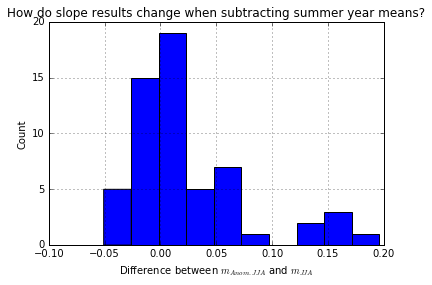

In [467]:
(anomaly_results['Anomaly m']- results_df['Slope']).hist()
plt.ylabel('Count')
plt.xlabel('Difference between $m_{Anom. JJA}$ and $m_{JJA}$')
plt.title('How do slope results change when subtracting summer year means?')

In [414]:
anomaly_results.columns

Index([u'City', u'Anomaly m', u'Anomaly r', u'Anomaly p'], dtype='object')

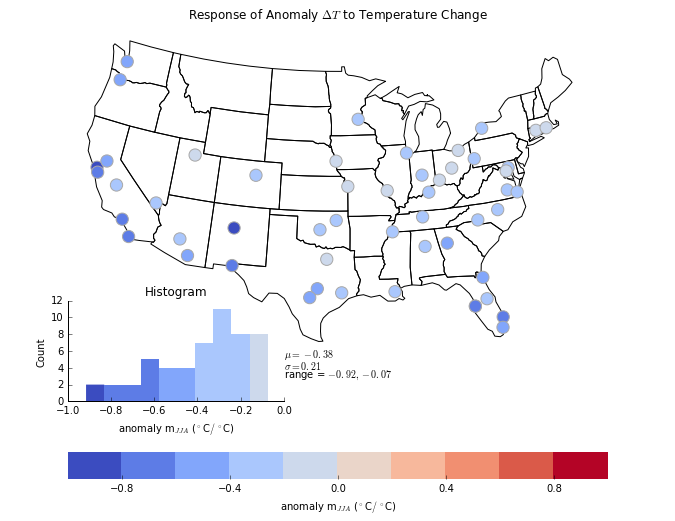

In [440]:
anomaly_results = pd.read_csv(results_filepath+'anomalyJJA/'+'anomaly_results.csv').set_index(paired_df.City)
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
data = anomaly_results.drop(drop_cities, axis = 0)['Anomaly m']
fig = map_hist_plot(data, paired_df, title = 'Response of Anomaly $\Delta T$ to Temperature Change', 
                    data_label = 'anomaly m$_{JJA}$ ($^\circ$C$ / ^\circ $C)', 
                   c_insignificant = anomaly_results[anomaly_results['Anomaly p']>0.05]) 
plt.savefig(results_filepath+ 'anomalyJJAslopes.pdf', bbox_inches='tight')

In [42]:
results_filepath + results_filename

'plots/version2/US_results_cleaned_data.csv'

In [45]:
results_df = pd.read_csv(results_filepath + results_filename)

In [7]:
results_df = pd.read_csv(results_filepath + results_filename).drop(1).set_index('City')
results_df = results_df[results_df['Data points']>0]

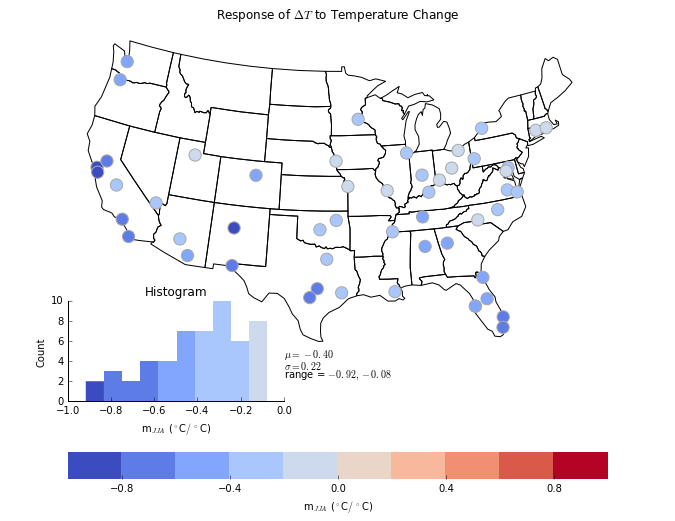

In [438]:
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
data = results_df.drop(drop_cities, axis = 0)['Slope'] #slopes

fig = map_hist_plot(data, paired_df) 
plt.savefig(results_filepath+ 'JJAslopes.pdf', bbox_inches='tight')

In [436]:
results_filepath

'plots/version2/'

In [352]:
# load error bars
results_filepath_error_bars = 'plots/version2/UHIvariance/' 
cities = paired_df['City'].values
UHI_std = []
for i in range(0,paired_df.shape[0]): # probalby need to redo 1-15
    city = paired_df.iloc[i]['City']
    if city == 'Grand Prairie': 
        city = 'Arlington'
    try: 
        array = np.load(results_filepath_error_bars+'UHIs/'+ city.replace(" ", "")[0:5]+'UHI.npy')
        array = array[~np.isnan(array)]
        UHI_std.append(array.std())
    except IOError: 
        print('Skipping %s'%city)

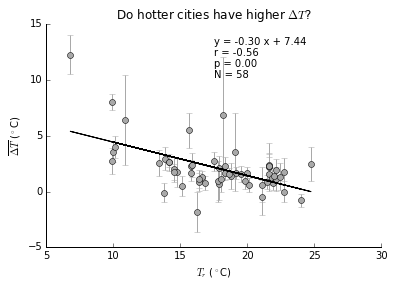

In [361]:
# hw_scatter(results_df['Mean JJA Rural Temp'],results_df['Mean UHI'],
#              'Do hotter cities have higher $\Delta T$?', 
#              '$T_r$ ($^\circ$C)', '$\overline{\Delta T}$ ($\Delta ^\circ$C)')
x = results_df['Mean JJA Rural Temp']
y = results_df['Mean UHI']
plt.errorbar(x, y, yerr = UHI_std, fmt='o', color = 'DarkGray')
hw_scatter(results_df['Mean JJA Rural Temp'],results_df['Mean UHI'],
             'Do hotter cities have higher $\Delta T$?', 
             '$T_r$ ($^\circ$C)', '$\overline{\Delta T}$ ($^\circ$C)')
prettify_plot()
plt.savefig(results_filepath+ 'meantempvsmeanUHI.pdf')

In [433]:
results_df.columns

Index([u'Unnamed: 0', u'Slope', u'Intercepts', u'Residual', u'Correlation',
       u'P-value', u'Urban start date', u'Urban end date', u'Rural start date',
       u'Rural end date', u'Data points', u'Mean UHI', u'Day of Max UHI',
       u'Mean JJA Rural Temp', u'UHI linear trend',
       u'UHI linear trend p-value', u'hw Slope', u'hw Residual',
       u'hw Correlation', u'hw Data points', u'hw Mean UHI',
       u'hw Mean JJA Rural Temp'],
      dtype='object')

In [416]:
results_df.columns

Index([u'Unnamed: 0', u'Slope', u'Intercepts', u'Residual', u'Correlation',
       u'P-value', u'Urban start date', u'Urban end date', u'Rural start date',
       u'Rural end date', u'Data points', u'Mean UHI', u'Day of Max UHI',
       u'Mean JJA Rural Temp', u'UHI linear trend',
       u'UHI linear trend p-value', u'hw Slope', u'hw Residual',
       u'hw Correlation', u'hw Data points', u'hw Mean UHI',
       u'hw Mean JJA Rural Temp'],
      dtype='object')

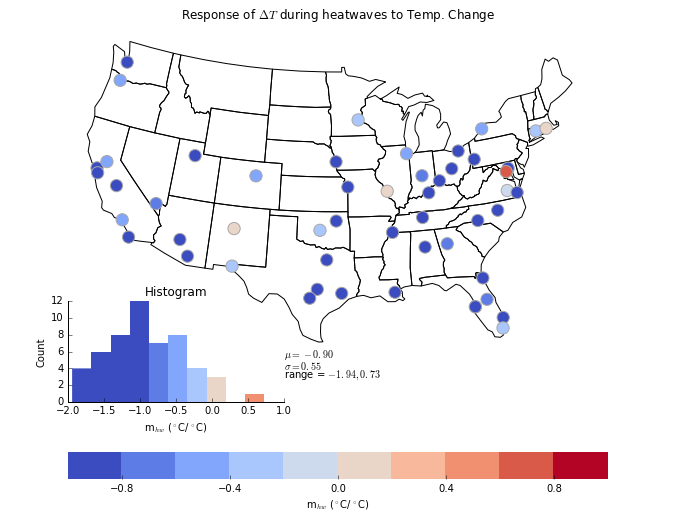

In [412]:
# Heatwave map
# note: c_insignificant = results_df[results_df['hw P-value']>0.05] but this data seems to not be saved? check older versions of file
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
data = results_df.drop(drop_cities, axis = 0)['hw Slope'] #slopes

fig = map_hist_plot(data, paired_df, title = 'Response of $\Delta T$ during heatwaves to Temp. Change', 
                    data_label='m$_{hw}$ ($^\circ$C/$^\circ$C)', 
                   c_insignificant = results_df[results_df['P-value']>0.05]) 
plt.savefig(results_filepath+ 'hwslopemap.pdf', bbox_inches='tight')

In [541]:
mean_summer_tvsdt.columns

Index([u'Unnamed: 0', u'm', u'r', u'p-value'], dtype='object')

In [418]:
# change over time: summer annual temps
mean_summer_tvsdt = pd.read_csv(results_filepath+'summermeans/'+'mean_summer_tvsdt_results.csv').set_index(paired_df.City)

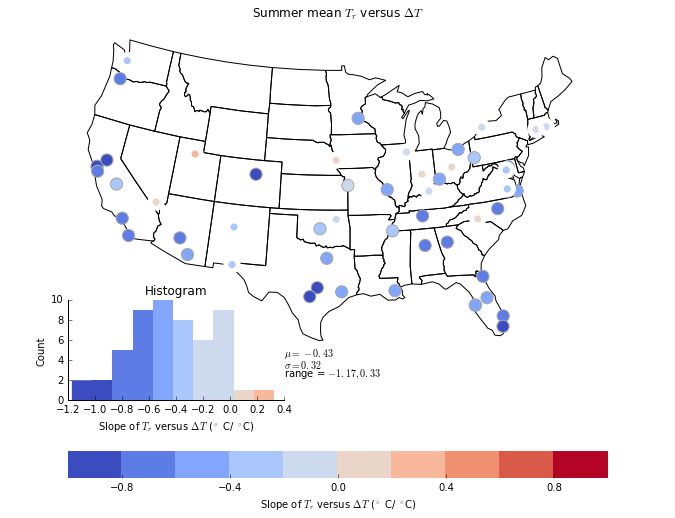

In [430]:
# change over time: summer annual temps versus UHI
mean_summer_tvsdt = pd.read_csv(results_filepath+'summermeans/'+'mean_summer_tvsdt_results.csv').set_index(paired_df.City)
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
data = mean_summer_tvsdt.drop(drop_cities)['m']
fig = map_hist_plot(data, paired_df, title = 'Slope of summer mean $T_r$ versus $\Delta T$', 
                    data_label='Slope of $T_r$ versus $\Delta T$ ($^\circ$ C/ $^\circ $C)', 
                  c_insignificant = mean_summer_tvsdt[mean_summer_tvsdt['p-value']>0.05]) 
#plt.savefig(results_filepath+ 'hwslopemap.pdf', bbox_inches='tight')

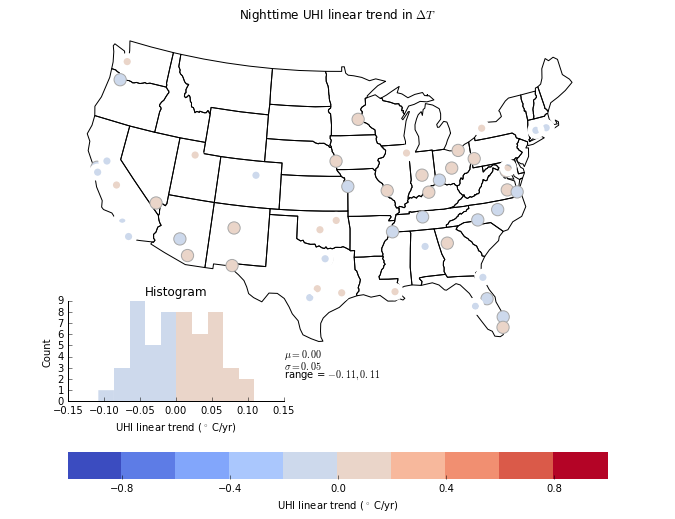

In [439]:
# linear trend in UHI
# check units- not sure if this is per year
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
data = mean_summer_tvsdt.drop(drop_cities)['m']
data = results_df.drop(drop_cities)['UHI linear trend']

fig = map_hist_plot(data, paired_df, title = 'Nighttime UHI linear trend in $\Delta T$', 
                    data_label='UHI linear trend ($^\circ$ C/yr)', 
                  c_insignificant = results_df[results_df['UHI linear trend p-value']>0.05]) 
plt.savefig(results_filepath+ 'UHIlineartrend.pdf', bbox_inches='tight')

In [377]:
trend_resultDF = pd.read_csv(results_filepath+'30yrtrend/trend_results.csv').drop(2)

In [368]:
# load error bars
results_filepath_error_bars = 'plots/version2/UHIvariance/' 
cities = paired_df['City'].values
slopes_std = []
for i in range(0,paired_df.shape[0]): # probalby need to redo 1-15
    city = paired_df.iloc[i]['City']
    if city == 'Grand Prairie': 
        city = 'Arlington'
    try: 
        array = np.load(results_filepath_error_bars+'slopes/'+ city.replace(" ", "")[0:5]+'m.npy')
        array = array[~np.isnan(array)]
        slopes_std.append(array.std())
    except IOError: 
        print('Skipping %s'%city)

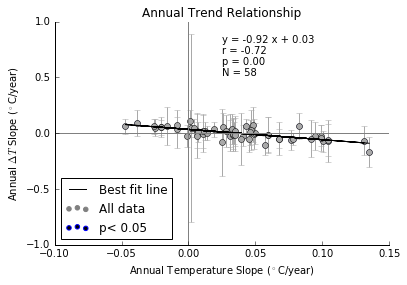

In [378]:
x = trend_resultDF['Annual Temp Slope']
y =  trend_resultDF['Annual UHI Slope']
plt.errorbar(x, y, yerr = slopes_std, fmt='o', color = 'DarkGray')

hw_scatter(trend_resultDF['Annual Temp Slope'], trend_resultDF['Annual UHI Slope'],
           'Annual Trend Relationship', 'Annual Temperature Slope ($^\circ$C/year)', 'Annual $\Delta T$ Slope ($^\circ$C/year)')

plt.scatter(trend_resultDF[(trend_resultDF['Temp p-value'] < .05) & (trend_resultDF['UHI p-value']<.05)]['Annual Temp Slope'], 
           trend_resultDF[(trend_resultDF['Temp p-value'] < .05) & (trend_resultDF['UHI p-value']<.05)]['Annual UHI Slope'], 
           color = 'black', edgecolor = 'blue')

plt.legend(['Best fit line', 'All data', 'p< 0.05'], loc = 3)

plt.axhline(0, color = 'gray')
plt.axvline(0, color = 'gray')
prettify_plot()
plt.savefig(results_filepath+'30yeartrend.pdf')

In [303]:
trend_resultDF = trend_resultDF.drop(2)

In [310]:
trend_resultDF[(trend_resultDF['Temp p-value'] < .05) & (trend_resultDF['UHI p-value']<.05)].shape

(19, 11)

In [305]:
(trend_resultDF['Annual Temp Slope']>0).sum()

48

In [311]:
(trend_resultDF[trend_resultDF['Annual Temp Slope']>0]['Annual UHI Slope'] < 0).sum()

28

In [312]:
(trend_resultDF['Annual Temp Slope']<0).sum()

10

In [313]:
(trend_resultDF[trend_resultDF['Annual Temp Slope']<0]['Annual UHI Slope'] > 0).sum()

9

In [309]:
# number of points which don't fit the story: warming but UHI increasing
(trend_resultDF[trend_resultDF['Annual Temp Slope']>0]['Annual UHI Slope'] > 0).sum()

20

In [330]:
trend_resultDF['Annual Temp Slope'].describe()

count    58.000000
mean      0.036885
std       0.041853
min      -0.047103
25%       0.006567
50%       0.033759
75%       0.059268
max       0.134933
Name: Annual Temp Slope, dtype: float64

In [331]:
trend_resultDF['Annual UHI Slope'].describe()

count    58.000000
mean      0.000152
std       0.053657
min      -0.168602
25%      -0.039665
50%       0.000293
75%       0.042268
max       0.108919
Name: Annual UHI Slope, dtype: float64

In [379]:
cols = np.arange(-5,6)
compositeTempDF = pd.read_csv((results_filepath + 'composite_temp.csv'), header = None, names =  cols).set_index(results_df.index)
compositeUHIDF = pd.read_csv((results_filepath + 'composite_UHI.csv'), header = None, names =  cols).set_index(results_df.index)

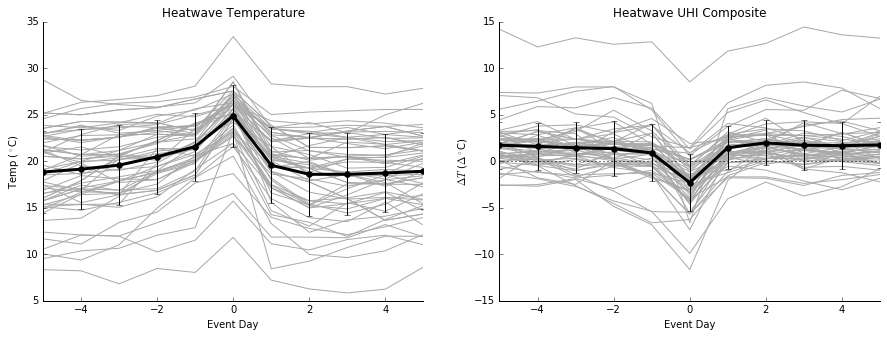

In [401]:
# heatwave composite 
#compositeUHIDF = pd.read_csv(results_filepath + 'composite_UHI.csv')
#compositeTempDF = pd.read_csv(results_filepath + 'composite_temp.csv')

x = np.arange(-5,6)
# plot heatwave composites for all stations
plt.figure(figsize = [15,5])
#plot temperature,raw
plt.subplot(1,2,1)
for i in range(0, compositeTempDF.shape[0]) : 
    #print compositeUHIDF2.iloc[i].values[1:]
    plt.plot(x, compositeTempDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0)#, '-o')
plt.errorbar(x,compositeTempDF.mean(), yerr=compositeTempDF.std(), color = 'k', zorder = 1)
#compositeTempDF.mean(axis=0).plot(yerr = compositeTempDF.std(axis=0))
plt.plot( x, compositeTempDF.mean(), '-o', color = 'k', linewidth = 3)
plt.xlabel('Event Day')
plt.ylabel('Temp ($^\circ$C)')
plt.title('Heatwave Temperature')
plt.xlim([-5,5])
prettify_plot()

#plot UHI, raw
plt.subplot(1,2,2)

for i in range(0, compositeUHIDF.shape[0]) : 
    #print compositeUHIDF2.iloc[i].values[1:]
    plt.plot(x, compositeUHIDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0)#, '-o')
plt.plot( x, compositeUHIDF.mean(), '-o', color = 'k', linewidth = 3,)
plt.errorbar(x,compositeUHIDF.mean(), yerr=compositeUHIDF.std(), color = 'k', zorder = 1)
plt.axhline(0, linestyle = ':', color = 'k')

plt.xlabel('Event Day')
plt.xlim([-5,5])
plt.ylabel('$\Delta T$ ($\Delta^\circ$C)')
plt.title('Heatwave UHI Composite')
prettify_plot()

plt.savefig(results_filepath+ 'hwcomposite.pdf')

In [288]:
compositeUHIDF.mean() - compositeUHIDF.mean()[-5]

-5    0.000000
-4   -0.121328
-3   -0.265278
-2   -0.366608
-1   -0.820471
 0   -4.025335
 1   -0.260336
 2    0.257372
 3    0.000335
 4   -0.041463
 5    0.030050
dtype: float64

In [287]:
(compositeUHIDF[0]< 0).sum()

47

In [290]:
(compositeUHIDF[0]> 0).sum()

11

In [291]:
compositeUHIDF.shape

(58, 11)